In [1]:
import json
import numpy as np
import pandas as pd
import re
from datetime import datetime

In [2]:
docs = []
with open('/Users/ktulhu/Downloads/all.jsonl 7') as f:
    for line in f:
        docs.append(json.loads(line))

In [3]:
entities = set([line[2] for doc in docs for line in doc['label']])
entities_dict = {ent: [] for ent in entities}
entities_dict

{'Судья - женщина': [],
 'Подряд': [],
 'Купля-продажа': [],
 'Банковская гарантия': [],
 '2022 год': [],
 '3 апелляция': [],
 '18 апелляция': [],
 'Цена контракта': [],
 'Судья - мужчина': [],
 'Сумма долга': [],
 '7 апелляция': [],
 'Услуги': [],
 '9 апелляция': [],
 '2021 год': [],
 '13 апелляция': [],
 'Заявленный размер неустойки (цифра)': [],
 '15 апелляция': [],
 'Договорная неустойка (%)': [],
 'Взысканный размер неустойки в 1 инстанции (цифра)': [],
 'Аренда': [],
 '2023 год': [],
 'Авансовый платеж': [],
 'Период просрочки/кол-во дней просрочки': [],
 '17 апелляция': [],
 '11 апелляция': [],
 'Поставка': [],
 '5 апелляция': []}

In [4]:
for doc in docs: # проходимся по всем документам в корпусе
    
    # проходимся по всем существующим сущностям
    for key in entities_dict:

        # для данного документа (doc) проходимся по всем сущностям, который у него есть (doc['label']) (неоптимально!)
        for entity in doc['label']:
            
            # если сущность документа (entity[2]) совпала с искомой сущностью в словаре (key), то
            if entity[2] == key:
                
                # достаём индексы начала и конца сущности в тексте документа
                start, end = entity[:2]
                
                # достаём из текста документа сущность (doc['text'][start:end]) и кладём её в словарь
                entities_dict[key].append(doc['text'][start:end])
                break
                
        else: # если сущность не нашлась, кладём пустую строку
            entities_dict[key].append('')

In [5]:
# создаём таблицу из словаря
df = pd.DataFrame(entities_dict)

In [6]:
df.iloc[31]['Договорная неустойка (%)'] = ''
df.iloc[40]['Договорная неустойка (%)'] = ''
df.iloc[61]['Договорная неустойка (%)'] = ''
df.iloc[62]['Договорная неустойка (%)'] = ''
df.iloc[70]['Договорная неустойка (%)'] = ''

In [7]:
df.drop([32], inplace=True)

In [8]:
def preprocess_money_sum(text):
    if text:
        text = re.sub(' ?ру.*', '', text)
        text = re.sub(',.+', '', text)
        text = text.replace(' ', '').replace('.', '').replace('\n', '')
        text = re.sub('[()А-ЯЁа-яё]', '', text)
        if not text:
            return
        return int(text)

In [10]:
df['claimed_penalty'] = df['Заявленный размер неустойки (цифра)'].apply(preprocess_money_sum)
df['resulting_penalty'] = df['Взысканный размер неустойки в 1 инстанции (цифра)'].apply(preprocess_money_sum)

In [11]:
df['penalty_reduction_ratio'] = [
    1 - resulting / claimed
    for (claimed, resulting) in df[['claimed_penalty', 'resulting_penalty']].values
]

In [12]:
percent_replace_dict = {
    'одной десятой процента': 0.001,
    '10 (десять) процентов от суммы каждой операции, совершенной не с использованием Отдельного счёта». ': 0.1,
}

In [13]:
def transform_percentage_data(cell):
    if cell:
        for special_case in percent_replace_dict:
            if special_case in cell:
                return percent_replace_dict[special_case]
        
        cell = re.sub('[а-яё% ]', '', cell).replace(',', '.').strip(' .')
        if cell:
            return float(cell) / 100

df['contract_penalty_percentage'] = df['Договорная неустойка (%)'].apply(transform_percentage_data)

In [14]:
df['debt_amount'] = df['Сумма долга'].apply(preprocess_money_sum)

In [15]:
df['prepayment'] = df['Авансовый платеж'].apply(preprocess_money_sum)

In [16]:
df['contract_price'] = df['Цена контракта'].apply(preprocess_money_sum)

In [17]:
def process_period(cell):
    if not cell:
        return
    
    try:
        cell = re.sub('(\\d) ?\. ?(\\d)', '\\1.\\2', cell)
        found_dates = re.findall('\\d\\d\.\\d\\d\.\\d\\d\\d\\d', cell)
        start, end = found_dates[0], found_dates[1]
        start_date = datetime.strptime(start, '%d.%m.%Y')
        end_date = datetime.strptime(end, '%d.%m.%Y')
        return (end_date - start_date).days
        
    except IndexError:
        
        try:
            num_days = re.match('\\d+', cell.strip()).group(0)
            return int(num_days)
        
        except Exception as e:
            print(e)

In [18]:
df['delay'] = df['Период просрочки/кол-во дней просрочки'].apply(process_period)

'NoneType' object has no attribute 'group'


In [19]:
appeal_cols = [f'{i} апелляция' for i in range(1, 19) if f'{i} апелляция' in df.columns]
# df[appeal_cols]

In [20]:
type_of_contract_cols = ['Аренда', 'Поставка', 'Купля-продажа', 'Подряд', 'Банковская гарантия', 'Услуги',]
# df[type_of_contract_cols]

In [21]:
judge_gender_cols = ['Судья - мужчина', 'Судья - женщина']
# df[judge_gender_cols]

In [22]:
year_cols = ['2022 год', '2021 год',  '2023 год']
# df[year_cols]

In [23]:
def transform_related_features(row, columns):
    return [col for col in columns if not row[col] == '']

In [24]:
df['appeal_courts'] = df.apply(transform_related_features, args=(appeal_cols,), axis=1)
df['appeal_courts'] = df.appeal_courts.apply(lambda cell: cell[0] if cell else None)

In [25]:
df['type_of_contract'] = df.apply(transform_related_features, args=(type_of_contract_cols,), axis=1)
df['type_of_contract'] = df.type_of_contract.apply(lambda cell: cell[0] if cell else None)

In [26]:
df['judge_gender'] = df.apply(transform_related_features, args=(judge_gender_cols,), axis=1)
df['judge_gender'] = df.judge_gender.apply(lambda cell: cell[0] if cell else None)

In [27]:
df['year'] = df.apply(transform_related_features, args=(year_cols,), axis=1)
df['year'] = df.year.apply(lambda cell: cell[0] if cell else None)

In [28]:
df.to_csv('annotated_docs_2.09.csv', index=False)

### Какие признаки берём и почему

1. claimed_penalty -- Заявленный размер неустойки (цифра)
2. contract_penalty_percentage -- Договорная неустойка (%): **заполняем наны 0.001**
4. contract_price -- Цена контракта
5. delay -- период просрочки, обычно есть
6. debt_amount -- Сумма долга
7. responsibility_limit -- Лимит ответсвенности --- его почти нет, но мы можем заполнить стандартным 0.1

Не берём:
- Досудебное погашение основного долга (цифра) -- его мало, не знаем как заполнять
- Авансовый платеж (Возможно, убираем, потому что его очень мало) -- слишком мало

In [29]:
df.columns

Index(['Судья - женщина', 'Подряд', 'Купля-продажа', 'Банковская гарантия',
       '2022 год', '3 апелляция', '18 апелляция', 'Цена контракта',
       'Судья - мужчина', 'Сумма долга', '7 апелляция', 'Услуги',
       '9 апелляция', '2021 год', '13 апелляция',
       'Заявленный размер неустойки (цифра)', '15 апелляция',
       'Договорная неустойка (%)',
       'Взысканный размер неустойки в 1 инстанции (цифра)', 'Аренда',
       '2023 год', 'Авансовый платеж',
       'Период просрочки/кол-во дней просрочки', '17 апелляция',
       '11 апелляция', 'Поставка', '5 апелляция', 'claimed_penalty',
       'resulting_penalty', 'penalty_reduction_ratio',
       'contract_penalty_percentage', 'debt_amount', 'prepayment',
       'contract_price', 'delay', 'appeal_courts', 'type_of_contract',
       'judge_gender', 'year'],
      dtype='object')

In [30]:
training_df = df[[
    'claimed_penalty', 'contract_penalty_percentage', 'prepayment',
    'contract_price', 'delay', 'debt_amount', 'penalty_reduction_ratio',
    'appeal_courts', 'type_of_contract', 'judge_gender', 'year',
]]

In [32]:
training_df.to_csv('training_df_unfilled_11.09.csv', index=False)

In [33]:
training_df[training_df.contract_price.isnull()].shape[0]

22

In [34]:
len(training_df)

125

<Axes: >

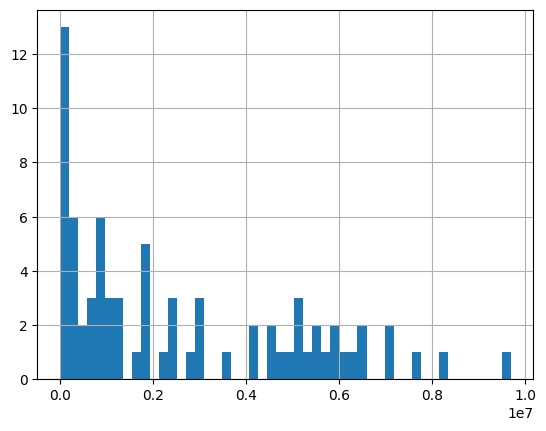

In [220]:
training_df[
    training_df.contract_price.notnull()
    & (training_df.contract_price < 10 ** 7)
].contract_price.hist(bins=50)

In [35]:
import numpy as np

In [36]:
training_df.contract_penalty_percentage.fillna(0.001, inplace=True)

/var/folders/zy/214v8d1d4tng0_jtxf69crf40000gp/T/ipykernel_3717/3724536266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df.contract_penalty_percentage.fillna(0.001, inplace=True)


In [37]:
for i, val in enumerate(training_df.delay):
    if np.isnan(val):
        new_value = round(np.random.pareto(10) * 1000) + 7
        training_df['delay'].iloc[i] = new_value

/var/folders/zy/214v8d1d4tng0_jtxf69crf40000gp/T/ipykernel_3717/1396771398.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df['delay'].iloc[i] = new_value


In [38]:
training_df['undefined_contract_price'] = training_df.contract_price.isnull()

/var/folders/zy/214v8d1d4tng0_jtxf69crf40000gp/T/ipykernel_3717/398954149.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df['undefined_contract_price'] = training_df.contract_price.isnull()


In [39]:
training_df['contract_price'] = [
    p if not np.isnan(p)
    else max(training_df.contract_price.median(), penalty, prepayment)
    for (p, penalty, prepayment) in training_df[
        ['contract_price', 'claimed_penalty', 'prepayment']
    ].values
]

/var/folders/zy/214v8d1d4tng0_jtxf69crf40000gp/T/ipykernel_3717/2785870993.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df['contract_price'] = [


In [40]:
training_df['debt_amount'] = [
    p if not np.isnan(p)
    else min(training_df.debt_amount.median(), contract_price)
    for (p, contract_price) in training_df[
        ['debt_amount', 'contract_price']
    ].values
]

/var/folders/zy/214v8d1d4tng0_jtxf69crf40000gp/T/ipykernel_3717/1535034192.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df['debt_amount'] = [


In [41]:
training_df.to_csv('training_data_filled_11.09.csv', index=False)

In [197]:
training_df.shape

(125, 12)